In [106]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [107]:
!wandb login 9676e3cc95066e4865586082971f2653245f09b4

wandb: Appending key for api.wandb.ai to your netrc file: /Users/guydavidson/.netrc
Successfully logged in to Weights & Biases!


In [108]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
from scipy.special import factorial

from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib import path as mpath
import matplotlib.gridspec as gridspec

import pickle
import tabulate
import wandb
from collections import namedtuple

import meta_learning_data_analysis as analysis
import meta_learning_analysis_plots as plots

In [109]:
np.set_printoptions(linewidth=160)
# Avoid escaping any latex characters
tabulate.LATEX_ESCAPE_RULES = {}

MIN_FONT_SIZE = 14
LABELS_FONT_SIZE = 20
TITLE_FONT_SIZE = 24

matplotlib.rcParams.update({'font.size': MIN_FONT_SIZE})
FONT_DICT = dict(fontsize=LABELS_FONT_SIZE) 
TITLE_FONT_DICT = dict(fontsize=TITLE_FONT_SIZE)

PER_PLOT_WIDTH = 6

QUERY_ORDINAL_POSITION_COMORLAP= 'cool'
NUM_TIMES_TRAINED_COLORMAP = 'copper'

In [110]:
cache = analysis.refresh_cache()
print(cache.keys())

dict_keys(['six_replications_analyses', 'control_analyses', 'query_mod_replications', 'six_replications_updated_analyses', 'updated_control_analyses', 'query_mod_updated_analyses', 'forgetting_curves_raw_data', 'preliminary_maml_analyses', 'baseline_maml_comparison_analyses', 'maml_analyses', 'maml_alpha_0_analyses', 'maml_meta_test_analyses', 'balanced_batches_analyses', 'baseline_total_curve_analyses', 'control_total_curve_analyses', 'query_mod_total_curve_analyses', 'simultaneous_training_analyses', 'per_task_simultaneous_training_analyses', 'task_conditional_analyses', 'task_conditional_multiplicative_only_analyses', 'task_conditional_additive_only_analyses', 'task_conditional_weights', 'task_conditional_multiplicative_only_weights', 'task_conditional_additive_only_weights', 'forgetting_exp_decay_params', 'baseline_ratio_curriculum_analyses', 'baseline_power_curriculum_analyses', 'epochs_to_completion', 'ratio_curriculum_1_5_analyses', 'power_curriculum_2_analyses', 'length_by_task

In [111]:
six_replications_updated_analyses = cache['six_replications_updated_analyses']
control_updated_analyses = cache['updated_control_analyses']
query_mod_updated_analyses = cache['query_mod_updated_analyses']
baseline_ratio_curriculum_analyses = cache['baseline_ratio_curriculum_analyses']
baseline_power_curriculum_analyses = cache['baseline_power_curriculum_analyses']
ratio_curriculum_1_5_analyses = cache['ratio_curriculum_1_5_analyses']
power_curriculum_2_analyses = cache['power_curriculum_2_analyses']
epochs_to_completion = cache['epochs_to_completion']
length_by_task_order = cache['length_by_task_order']

# Combined Figure

In [143]:
NROWS = 2
NCOLS = 3
COL_WIDTH = 6
ROW_HEIGHT = 5 
WIDTH_SPACING = 2
HEIGHT_SPACING = 0


def create_combined_figure(analyses, sem_n=(60, 60, 60, 180), save_path=None):
    title_font_dict = TITLE_FONT_DICT.copy()
    title_font_dict['pad'] = 10

    multi_plot_font_dict = FONT_DICT.copy()
    multi_plot_font_dict['fontsize'] = 18

    figure = plt.figure(figsize=(NCOLS * COL_WIDTH + WIDTH_SPACING, NROWS * ROW_HEIGHT + HEIGHT_SPACING))
    plt.subplots_adjust(hspace=0.4, wspace=0.35)


    raw_accuracy_axes = (plt.subplot(NROWS, NCOLS, 1), plt.subplot(NROWS, NCOLS, NCOLS + 1))
    plots.both_raw_accuracy_plots(analyses, '',
                                  shade_error=True, font_dict=multi_plot_font_dict, log_x=True,
                                  new_task_colormap=QUERY_ORDINAL_POSITION_COMORLAP, 
                                  first_task_colormap=NUM_TIMES_TRAINED_COLORMAP, title_font_dict=title_font_dict,
                                  hline_y=0.95, first_task_title='', new_task_title='', add_colorbars=False,
                                  external_axes=raw_accuracy_axes)


    examples_to_criterion_axes = (plt.subplot(NROWS, NCOLS, 2), plt.subplot(NROWS, NCOLS, NCOLS + 2))
    LOG_PLOT_YLIM = (7.75, 13.25)
    plots.plot_processed_results_all_dimensions(analyses, data_index=1, 
                                                title='',
                                                ylim=LOG_PLOT_YLIM, log_x=True, log_y=True, sem_n=sem_n, shade_error=True,
                                                font_dict=multi_plot_font_dict, times_trained_colormap=QUERY_ORDINAL_POSITION_COMORLAP, 
                                                tasks_trained_colormap=NUM_TIMES_TRAINED_COLORMAP,
                                                dimension_names=('',), dimension_indices=(3,),
                                                # num_tasks_trained_highlight_first_time='highlight', 
                                                add_colorbars=False,
                                                title_font_dict=TITLE_FONT_DICT, external_axes=examples_to_criterion_axes,
                                                plot_regression='print', num_tasks_to_plot_tasks_trained=1,
                                                tasks_trained_y_label='Log(New task trials to criterion)')


    accuracy_22point5k_axes = (plt.subplot(NROWS, NCOLS, 3), plt.subplot(NROWS, NCOLS, NCOLS + 3))
    ACCURACY_PLOT_YLIM = (0.5, 1.0)
    plots.plot_processed_results_all_dimensions(analyses, data_index=3, 
                                                title='', #'New episode, 22.5k accuracy, baseline model',
                                                sem_n=sem_n, shade_error=True, ylim=ACCURACY_PLOT_YLIM, 
                                                plot_y_label='Accuracy\nafter 22.5k trials',
                                                tasks_trained_y_label='New task accuracy\nafter 22.5k trials',
                                                font_dict=multi_plot_font_dict, times_trained_colormap=QUERY_ORDINAL_POSITION_COMORLAP, 
                                                tasks_trained_colormap=NUM_TIMES_TRAINED_COLORMAP,
                                                dimension_names=('',), dimension_indices=(3,),
                                                # num_tasks_trained_highlight_first_time='highlight',
                                                title_font_dict=TITLE_FONT_DICT, num_tasks_to_plot_tasks_trained=1,
                                                external_axes=accuracy_22point5k_axes)

    TEXT_POSITIONS = [(0.06, 0.85), (0.06, 0.42),
                      (0.3365, 0.85), (0.3365, 0.42),
                      (0.625, 0.85), (0.625, 0.42)]

    subfigure_text_font_dict = FONT_DICT.copy()
    subfigure_text_font_dict['fontsize'] += 4
    subfigure_text_font_dict['color'] = '#808080'
    subfigure_text_font_dict['weight'] = 'bold'

    num_subfigures = 6
    for i in range(num_subfigures):
        pos = TEXT_POSITIONS[i]
        plt.text(pos[0], pos[1], f'({chr(97 + i)})', 
                 subfigure_text_font_dict, transform=figure.transFigure)

    if save_path is not None:
        plots.save(save_path)
    
    plt.show()


# Baseline

log(y) = -1.603 log(x) + 11.71
log(y) = -0.447 log(x) + 12.3


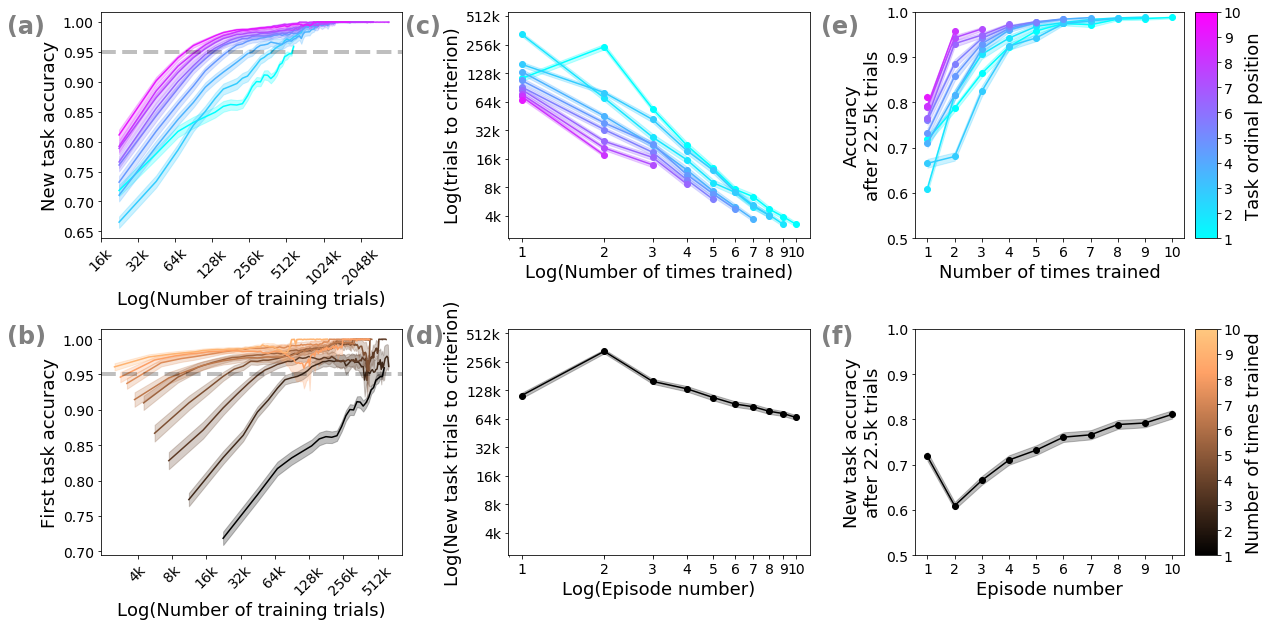

In [119]:
create_combined_figure(six_replications_updated_analyses)

# Ratio curriculum

log(y) = -1.403 log(x) + 11.52
log(y) = -0.354 log(x) + 12.2
Figure:

\begin{figure}[!htb]
% \vspace{-0.225in}
\centering
\includegraphics[width=\linewidth]{ch-results/figures/curricula/results_ratio_curriculum.pdf}
\caption{ {\bf FIGURE TITLE.} FIGURE DESCRIPTION.}
\label{fig:results-curricula-results-ratio-curriculum}
% \vspace{-0.2in}
\end{figure}


 Wrapfigure:

\begin{wrapfigure}{r}{0.5\linewidth}
\vspace{-.3in}
\begin{spacing}{1.0}
\centering
\includegraphics[width=0.95\linewidth]{ch-results/figures/curricula/results_ratio_curriculum.pdf}
\caption{ {\bf FIGURE TITLE.} FIGURE DESCRIPTION.}
\label{fig:results-curricula-results-ratio-curriculum}
\end{spacing}
% \vspace{-.25in}
\end{wrapfigure}



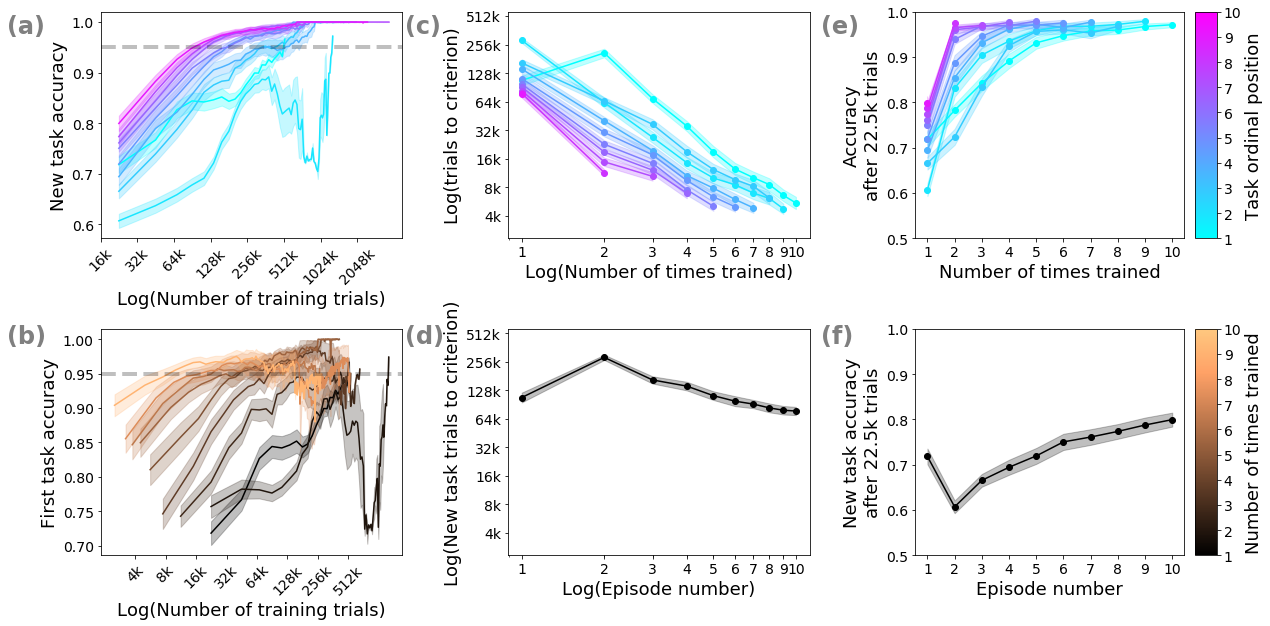

In [163]:
create_combined_figure(baseline_ratio_curriculum_analyses, sem_n=(20, 20, 20, 60),
                       save_path='curricula/results_ratio_curriculum.pdf')

# Ratio curriculum, suboptimal ratio

log(y) = -1.011 log(x) + 11.26
log(y) = -0.337 log(x) + 12.2
Figure:

\begin{figure}[!htb]
% \vspace{-0.225in}
\centering
\includegraphics[width=\linewidth]{ch-results/figures/curricula/results_ratio_1_5_curriculum.pdf}
\caption{ {\bf FIGURE TITLE.} FIGURE DESCRIPTION.}
\label{fig:results-curricula-results-ratio-1-5-curriculum}
% \vspace{-0.2in}
\end{figure}


 Wrapfigure:

\begin{wrapfigure}{r}{0.5\linewidth}
\vspace{-.3in}
\begin{spacing}{1.0}
\centering
\includegraphics[width=0.95\linewidth]{ch-results/figures/curricula/results_ratio_1_5_curriculum.pdf}
\caption{ {\bf FIGURE TITLE.} FIGURE DESCRIPTION.}
\label{fig:results-curricula-results-ratio-1-5-curriculum}
\end{spacing}
% \vspace{-.25in}
\end{wrapfigure}



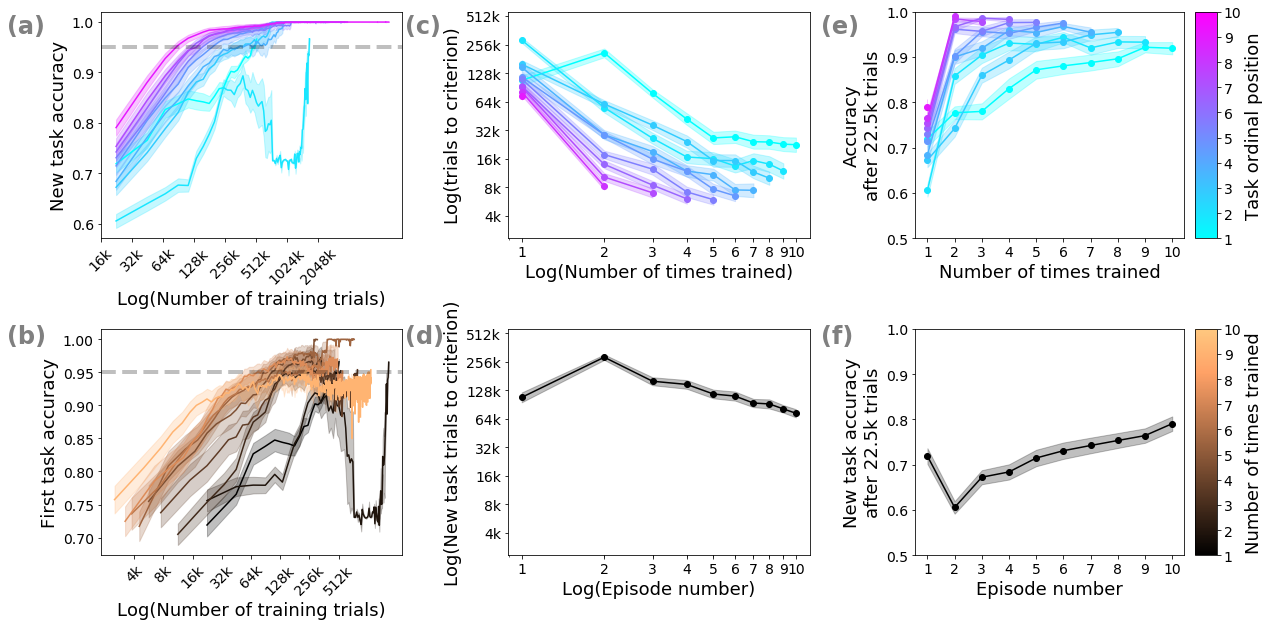

In [164]:
create_combined_figure(ratio_curriculum_1_5_analyses, sem_n=(20, 20, 20, 60),
                       save_path='curricula/results_ratio_1_5_curriculum.pdf')

# Power curriculum

log(y) = -1.441 log(x) + 11.5
log(y) = 0.0525 log(x) + 11.6
Figure:

\begin{figure}[!htb]
% \vspace{-0.225in}
\centering
\includegraphics[width=\linewidth]{ch-results/figures/curricula/results_power_curriculum.pdf}
\caption{ {\bf FIGURE TITLE.} FIGURE DESCRIPTION.}
\label{fig:results-curricula-results-power-curriculum}
% \vspace{-0.2in}
\end{figure}


 Wrapfigure:

\begin{wrapfigure}{r}{0.5\linewidth}
\vspace{-.3in}
\begin{spacing}{1.0}
\centering
\includegraphics[width=0.95\linewidth]{ch-results/figures/curricula/results_power_curriculum.pdf}
\caption{ {\bf FIGURE TITLE.} FIGURE DESCRIPTION.}
\label{fig:results-curricula-results-power-curriculum}
\end{spacing}
% \vspace{-.25in}
\end{wrapfigure}



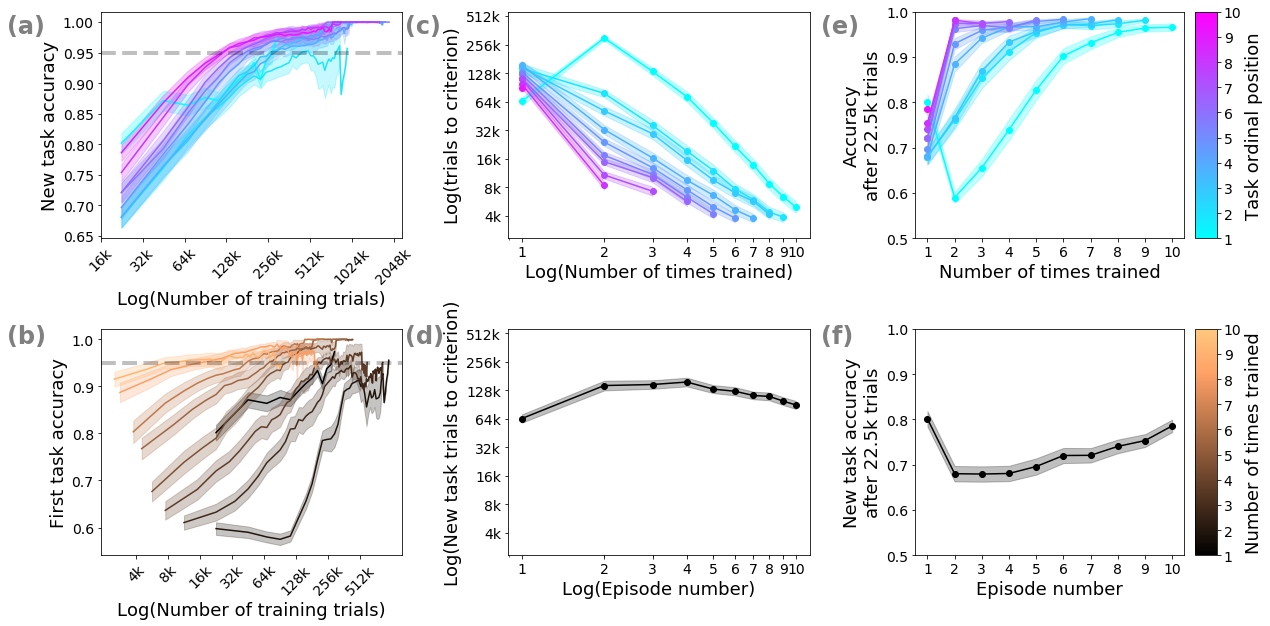

In [165]:
create_combined_figure(baseline_power_curriculum_analyses, sem_n=(20, 20, 20, 60),
                       save_path='curricula/results_power_curriculum.pdf')

# Power curriculum, different exponent

log(y) = -0.4275 log(x) + 11.03
log(y) = -0.158 log(x) + 11.5
Figure:

\begin{figure}[!htb]
% \vspace{-0.225in}
\centering
\includegraphics[width=\linewidth]{ch-results/figures/curricula/results_power_2_curriculum.pdf}
\caption{ {\bf FIGURE TITLE.} FIGURE DESCRIPTION.}
\label{fig:results-curricula-results-power-2-curriculum}
% \vspace{-0.2in}
\end{figure}


 Wrapfigure:

\begin{wrapfigure}{r}{0.5\linewidth}
\vspace{-.3in}
\begin{spacing}{1.0}
\centering
\includegraphics[width=0.95\linewidth]{ch-results/figures/curricula/results_power_2_curriculum.pdf}
\caption{ {\bf FIGURE TITLE.} FIGURE DESCRIPTION.}
\label{fig:results-curricula-results-power-2-curriculum}
\end{spacing}
% \vspace{-.25in}
\end{wrapfigure}



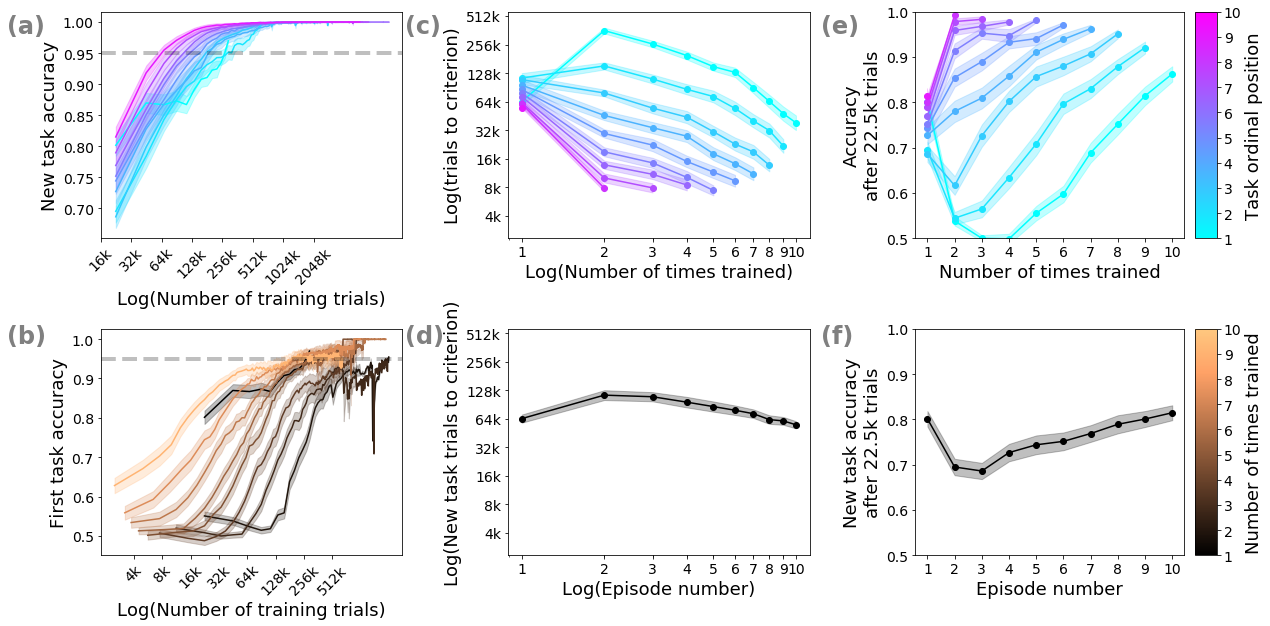

In [166]:
create_combined_figure(power_curriculum_2_analyses, sem_n=(20, 20, 20, 60),
                       save_path='curricula/results_power_2_curriculum.pdf')

# Taking a first stab at plotting the epochs to completion

In [167]:
DEFAULT_COLORMAP = plt.get_cmap('Dark2')
IGNORE_NAMES = ('heterogeneous')


def single_ax_epochs_to_completion(data, condition_index, ax, raw_or_log, plot_trials=True,
                                   cm=DEFAULT_COLORMAP, plot_sem=True, sem_n=10,
                                   ignore_names=IGNORE_NAMES):
    
    key = raw_or_log
    if plot_trials:
        key += '_trial'
    
    for i, name in enumerate(data.keys()):
        if name not in ignore_names:
            y = data[name][key][condition_index]
            if y is not None:
                x = np.arange(y.mean.shape[0]) + 1
                c = cm(i)

                ax.plot(x, y.mean, color=c, label=name)

                if plot_sem:
                    sem = y.std / (sem_n ** 0.5)
                    ax.fill_between(x, y.mean - sem, y.mean + sem, color=c, alpha=0.25)
    
    
    if raw_or_log == 'raw':
        raw_or_log = ''
        ymax = ax.get_ylim()[1]
        ax.set_yticks(np.arange(1, int(np.round(ymax / 1e6)), 2) * 1e6)
        
        def formatter(x, pos):
            return f'{int(x // 1000000)}M'
        
        ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(formatter))
        
    else:
        ylim = ax.get_ylim()
#         print(ylim)
        min_power_2, max_power_2 = int(np.round(ylim[0] / np.log(2))), int(np.round(ylim[1] / np.log(2)))
#         print(min_power_2, max_power_2)
        ax.set_yticks(np.arange(min_power_2, max_power_2 + 1) * np.log(2))
        
        def formatter(x, pos):
            return f'$2^ {{ {pos + min_power_2} }}$'
        
        ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(formatter))

    ax.set_ylabel(f'Cummulative {raw_or_log} {plot_trials and "trials" or "epochs"} to completion'.strip().title())
    
    ax.set_xticks(x)
    ax.set_xlabel('Episode')
    
    
def plot_epochs_to_completion(data, condition, plot_trials=True, cm=DEFAULT_COLORMAP, 
                              plot_sem=True, sem_n=10, ignore_names=IGNORE_NAMES, title=None):
    figure = plt.figure(figsize=(16, 6))
    if ignore_names is None:
        ignore_names = []

    condition_index = analysis.CONDITION_ANALYSES_FIELDS.index(condition)
    
    raw_ax = plt.subplot(1, 2, 1)
    single_ax_epochs_to_completion(data, condition_index, raw_ax, 'raw',
                                   plot_trials=plot_trials, cm=cm, plot_sem=plot_sem, 
                                   sem_n=sem_n, ignore_names=ignore_names)
    raw_ax.set_title('Raw')
    
    log_ax = plt.subplot(1, 2, 2)
    single_ax_epochs_to_completion(data, condition_index, log_ax, 'log',
                                   plot_trials=plot_trials, cm=cm, plot_sem=plot_sem, 
                                   sem_n=sem_n, ignore_names=ignore_names)
    log_ax.set_title('Log')
    
    legend_lines = [matplotlib.lines.Line2D([0], [0], color=cm(i), lw=4) 
                    for i, name in enumerate(data.keys())
                    if name not in ignore_names]
    plt.legend(legend_lines, data.keys(), bbox_to_anchor=(1.04,1), loc="upper left")
    plt.suptitle(title is not None and title or condition.title())
    

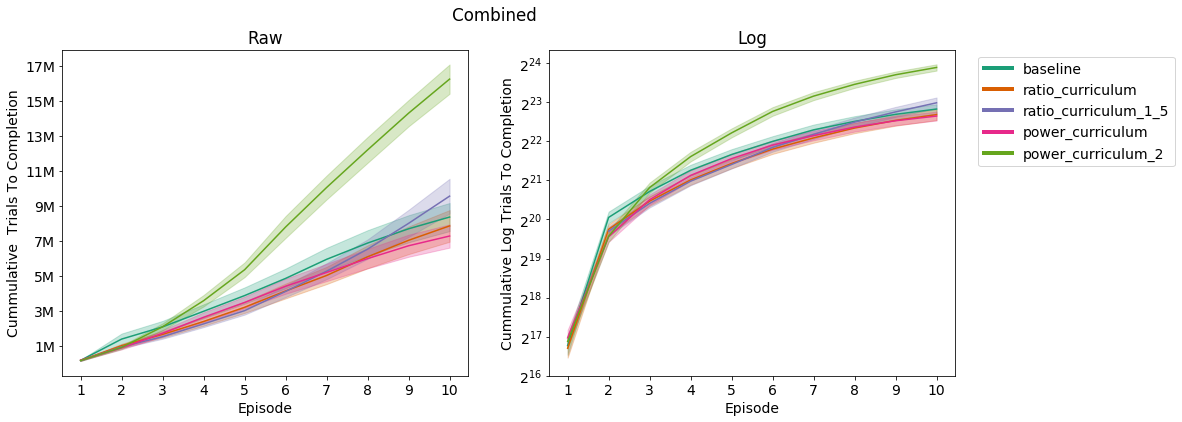

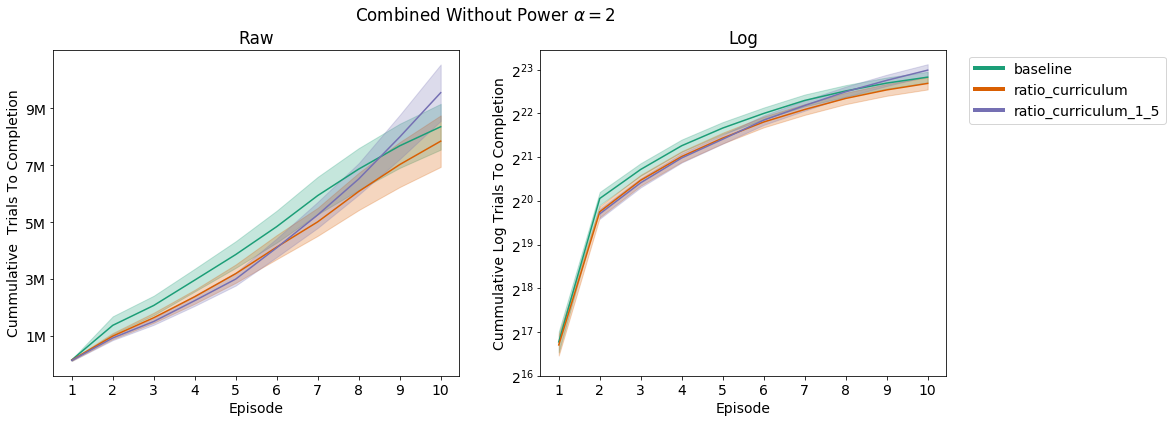

In [168]:
plot_epochs_to_completion(epochs_to_completion, analysis.COMBINED, sem_n=30)
plot_epochs_to_completion(epochs_to_completion, analysis.COMBINED, sem_n=30, 
                          ignore_names='power_curriculum_2', title='Combined Without Power $\\alpha = 2$')

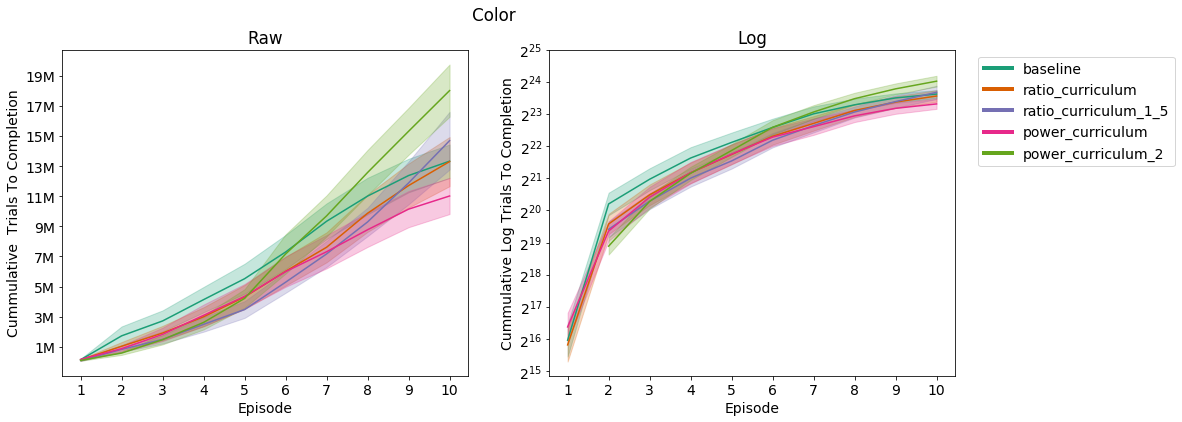

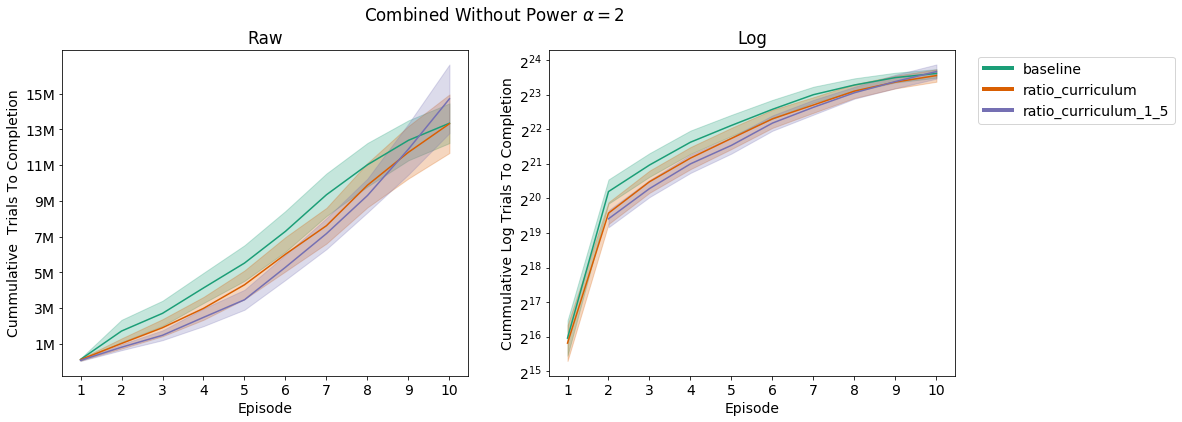

In [169]:
plot_epochs_to_completion(epochs_to_completion, analysis.COLOR)
plot_epochs_to_completion(epochs_to_completion, analysis.COLOR,
                          ignore_names='power_curriculum_2', title='Combined Without Power $\\alpha = 2$')


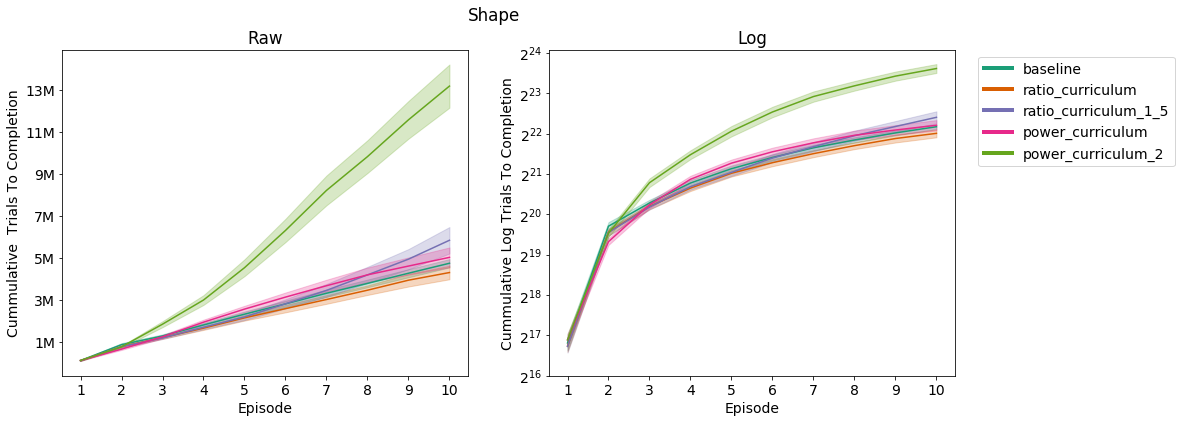

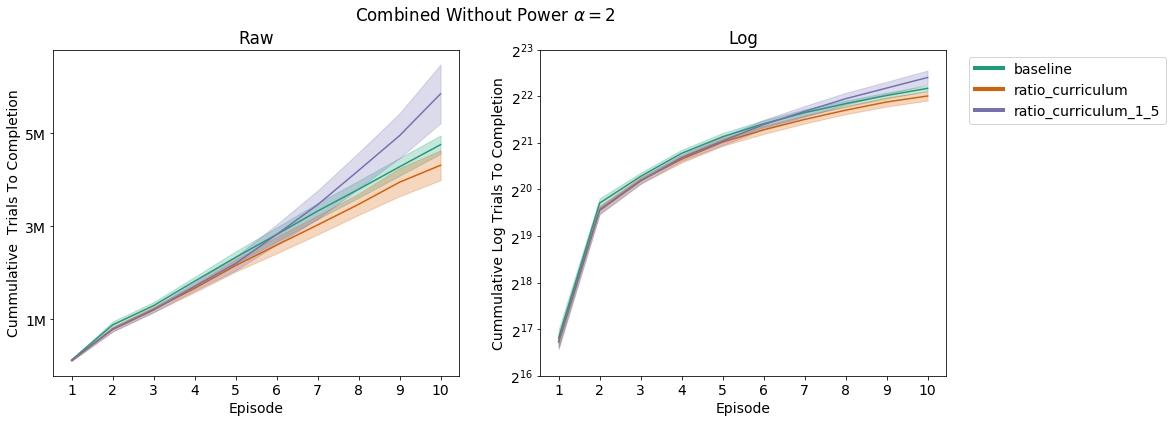

In [170]:
plot_epochs_to_completion(epochs_to_completion, analysis.SHAPE)
plot_epochs_to_completion(epochs_to_completion, analysis.SHAPE, 
                          ignore_names='power_curriculum_2', title='Combined Without Power $\\alpha = 2$')

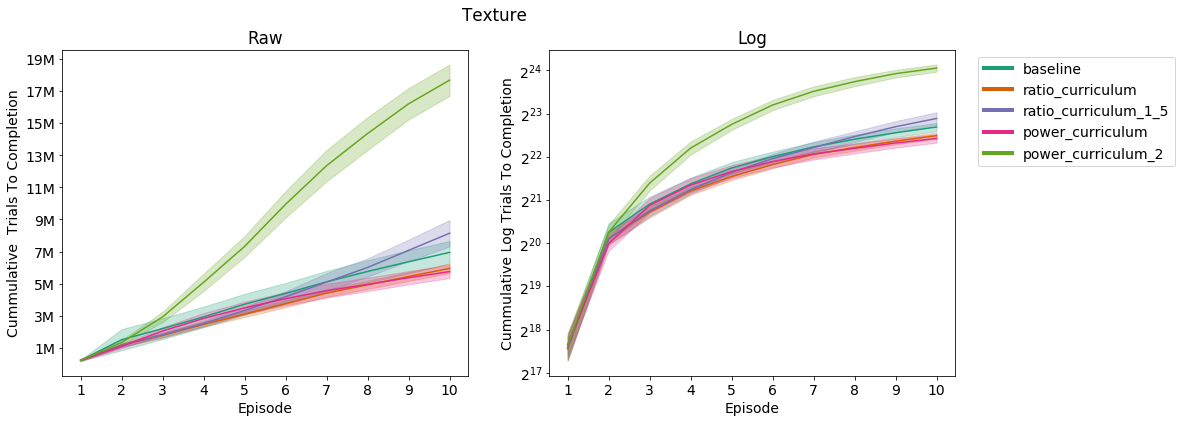

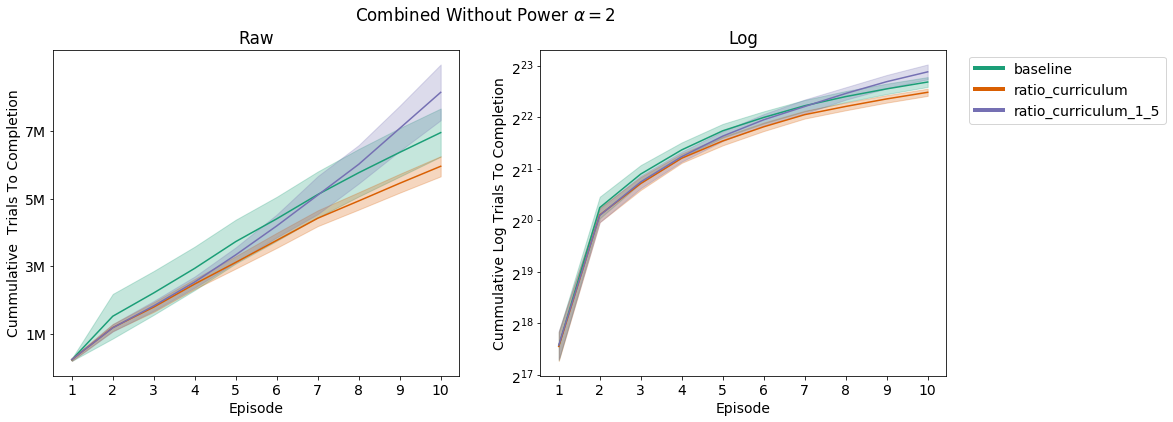

In [171]:
plot_epochs_to_completion(epochs_to_completion, analysis.TEXTURE)
plot_epochs_to_completion(epochs_to_completion, analysis.TEXTURE, 
                          ignore_names='power_curriculum_2', title='Combined Without Power $\\alpha = 2$')

# Last finished task

In [159]:
DEFAULT_COLORMAP = plt.get_cmap('Dark2')


def last_finished_tasks(epochs_to_completion, name, condition, plot_percent=True,
                        bar_width=0.1, bar_spacing=0.5, cm=DEFAULT_COLORMAP,
                        n_episodes=10):
    condition_index = analysis.CONDITION_ANALYSES_FIELDS.index(condition)
    
    relevant_last_tasks = np.array(epochs_to_completion[name]['last_tasks'][condition_index])
    
    count_per_episode = [np.bincount(relevant_last_tasks[:, i], minlength=i + 2)[1:] 
                         for i in range(relevant_last_tasks.shape[1])]
    
    figure = plt.figure(figsize=(16, 6))
    x_start = 0
    
    for i, episode_last_task_counts in enumerate(count_per_episode):
        n = i + 1
        x_values = x_start + np.arange(n) * bar_width
        y_values = episode_last_task_counts
        if plot_percent:
            y_values = y_values.astype(np.float)
            y_values/= np.sum(y_values)
        plt.bar(x_values, y_values, width=bar_width, color=[cm(i) for i in range(n)])
        x_start = x_values[-1] + bar_width + bar_spacing
        
    tick_locations = np.arange(n_episodes) * bar_spacing +\
        ( (np.arange(n_episodes) * np.arange(1, n_episodes +1) + np.arange(n_episodes) ) * (bar_width / 2))
    plt.xticks(tick_locations, np.arange(n_episodes) + 1)
    plt.xlabel('Episode')
    plt.ylabel(f'{plot_percent and "Percentage" or "Count"} Task Learned Last'.strip().title())
    
    legend_patches = [matplotlib.patches.Patch(color=cm(i), label=f'Task #{i + 1}') 
                      for i in range(n_episodes)]
    plt.legend(handles=legend_patches, loc='best', ncol=2)
    plt.title(f'{name} Last Learned Task'.title())
    plt.show()
    

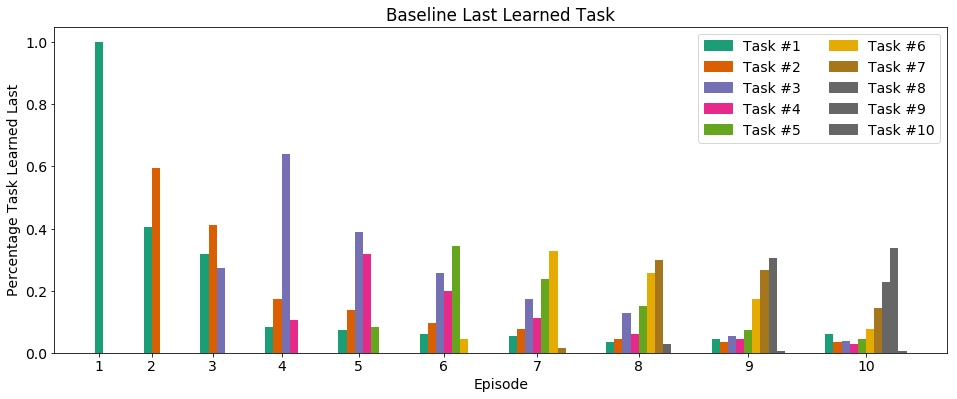

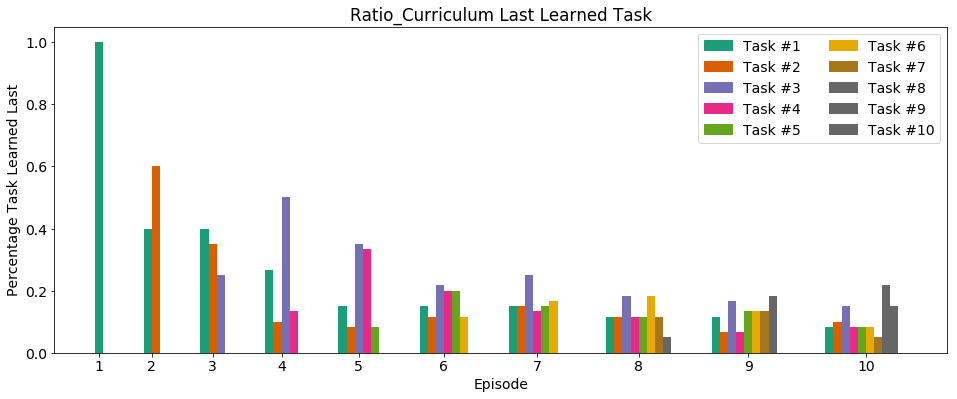

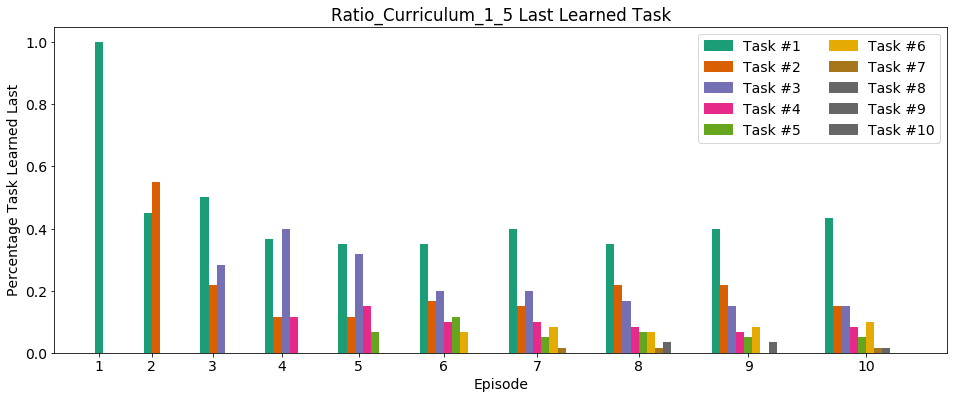

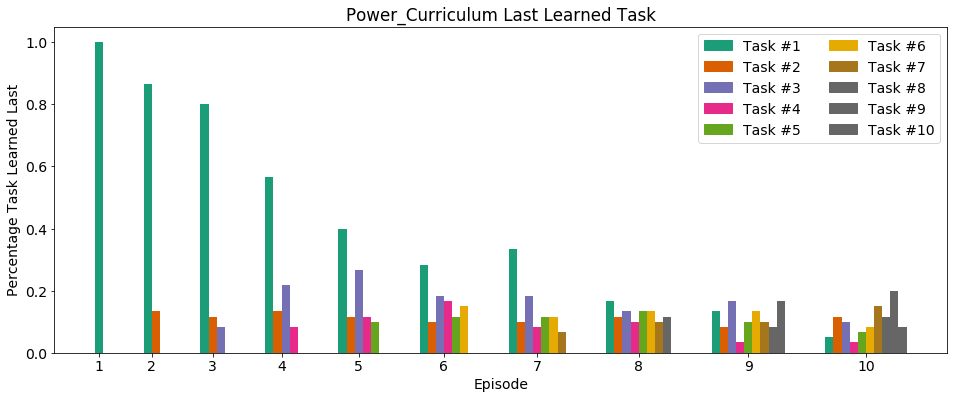

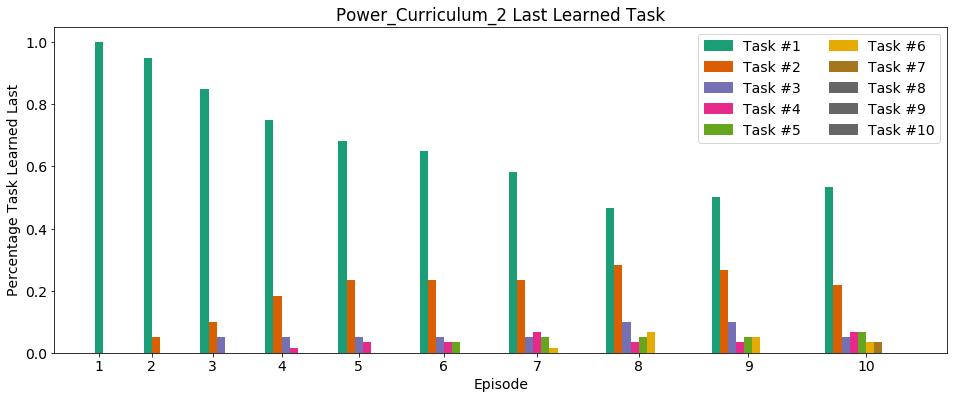

In [161]:
condition = 'combined'
for name in epochs_to_completion:
    last_finished_tasks(epochs_to_completion, name, condition)

# Length by ID

In [51]:
DEFAULT_COLORMAP = plt.get_cmap('Dark2')


def plot_length_by_id(length_by_task_order, condition, raw_or_normalized='normalized',
                      bar_width=0.1, bar_spacing_factor=1.5, cm=DEFAULT_COLORMAP):
    condition_index = analysis.CONDITION_ANALYSES_FIELDS.index(condition)
    
    num_sets = len(length_by_task_order)
    
    all_keys = [set(length_by_task_order[name][raw_or_normalized][condition_index].keys()) 
                for name in length_by_task_order]
    key_set = all_keys[0]
    for more_keys in all_keys[1:]:
        key_set.intersection_update(more_keys)
        
    sorted_keys = sorted(key_set)
    
    figure = plt.figure(figsize=(16, 6))
    
    for i, name in enumerate(length_by_task_order):
        values = np.array([length_by_task_order[name][raw_or_normalized][condition_index][key]
                           for key in sorted_keys])
        values -= np.min(values)
        
        x_values = bar_width * num_sets * bar_spacing_factor * np.arange(len(sorted_keys)) + i * bar_width
        
        plt.bar(x_values, values, width=bar_width, color=cm(i), label=name)
        
    tick_locations = (bar_width * num_sets * bar_spacing_factor * np.arange(len(sorted_keys))) + (num_sets / 2 * bar_width)
    plt.xticks(tick_locations, sorted_keys)
    plt.xlabel('Latin Square Index')
    plt.ylabel(f'{raw_or_normalized == "normalized" and "Normalized" or ""} completion length'.strip().title())
    plt.legend(loc='best')
    plt.title(condition)
    plt.show()
    

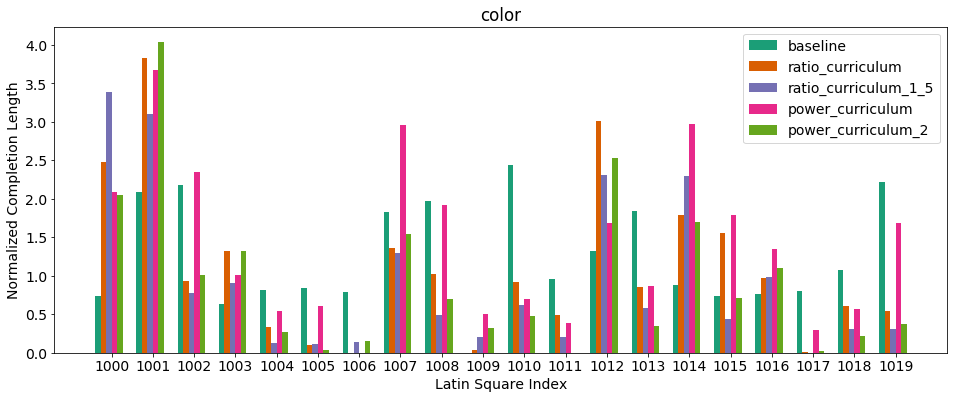

In [52]:
plot_length_by_id(length_by_task_order, 'color', bar_spacing_factor=1.5)

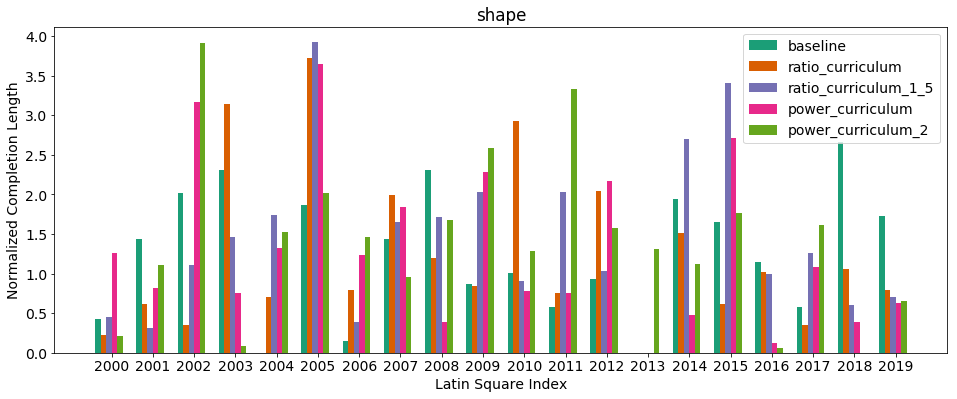

In [58]:
plot_length_by_id(length_by_task_order, 'shape', bar_spacing_factor=1.5)

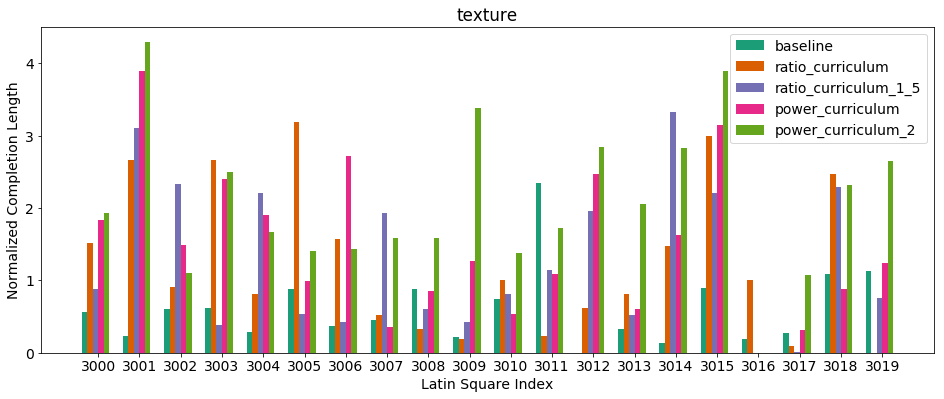

In [59]:
plot_length_by_id(length_by_task_order, 'texture', bar_spacing_factor=1.5)